<a href="https://colab.research.google.com/github/MateoMu/TDS_III/blob/master/Mini_Proyecto1_MateoMu%C3%B1ozArroyave.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

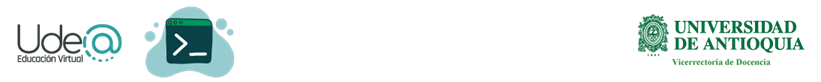


**Tratamiento de Señales III** *Mini-Proyecto 1*

**Adquisicion de datos y aplicación de técnicas de preprocesamiento para resolver un problema particular**

*Analisis de Bio-señales para Computación Afectiva*

*   Mateo Muñoz Arroyave
    CC 1036676919


**Autor:**
*   Hernán Felipe García Arias, PhD.



**Facultad de Ingeniería**

**Universidad de Antioquia**

---

##Importación de librerias

In [ ]:
import scipy.io as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Descargamos el archivo Emocional

#https://drive.google.com/file/d/1cNMil1P60z-XrqExnnKvmggmXWhI3glZ/view?usp=drive_link
!gdown '1cNMil1P60z-XrqExnnKvmggmXWhI3glZ'

Downloading...
From: https://drive.google.com/uc?id=1cNMil1P60z-XrqExnnKvmggmXWhI3glZ
To: /content/s14.mat
100% 80.6M/80.6M [00:01<00:00, 64.7MB/s]


###Se cargan todos los datos del paciente 1

In [ ]:
datosP1 = sc.loadmat('s14.mat')
signals = datosP1['data']
etiquetas = datosP1['labels']
# Esto me arrojará un nd array de n_video * id_signal * Ntimepoints

In [ ]:
from scipy.signal import argrelextrema
import pandas as pd
from scipy.signal import butter, lfilter, filtfilt


In [ ]:
def normalize_min_max(data):
    min_val = np.min(data)
    max_val = np.max(data)
    normalized_data = (data - min_val) / (max_val - min_val)
    return normalized_data


##Caracteristicas del GSR

- Minimos locales
- 10 potencias espectrales en la banda de [0-2.4] Hz
- Tiempo medio de subida

###Minimos locales GSR

In [ ]:

# Itera sobre cada conjunto de datos y encuentra los mínimos locales
def mini_local(GSR):
  datos_normalizados_GSR = normalize_min_max(GSR)
  minimos_locales = argrelextrema(datos_normalizados_GSR, np.less)[0]
  minimos_locales = len(minimos_locales)
  # Grafica los datos y los mínimos locales
  # plt.plot(datos_normalizados_GSR, label='Datos')
  # plt.scatter(minimos_locales, datos_normalizados_GSR[minimos_locales], color='red', label='Mínimos Locales')
  # plt.xlabel('Índice')
  # plt.ylabel('Valor')
  # plt.legend()
  # plt.xlim(5900, 6010)
  # plt.show()

  # print('Índices de mínimos locales:', minimos_locales)
  # print('Valores de mínimos locales:', datos_normalizados_GSR[minimos_locales])
  return minimos_locales

###10 potencias espectrales en las bandas 0-2.4Hz

In [ ]:
def Pot_Freq(GSR):

  # Definir los parámetros del filtro pasa banda (0.0-2.4 Hz)
  frec_corte_baja = 0.01
  frec_corte_alta = 2.4
  nyq = 0.5 * Fs
  frec_baja = frec_corte_baja / nyq
  frec_alta = frec_corte_alta / nyq

  # Diseñar el filtro pasa banda
  b, a = butter(N=4, Wn=[frec_baja, frec_alta], btype='band')

  # Aplicar el filtro pasa banda a la señal de GSR
  GSR_filtrada = lfilter(b, a, GSR) # Inicializar la matriz filtrada

  # Calcular la FFT de la señal filtrada
  fft_resultado = np.fft.fft(GSR_filtrada)
  fft_resultado_positivo = fft_resultado[:len(fft_resultado)//2]
  frecuencias = np.fft.fftfreq(len(fft_resultado_positivo), d=Fs/len(fft_resultado_positivo))

  # Calcula las potencias espectrales en la banda de 0 a 2.4 Hz
  potencias_banda = np.abs(fft_resultado_positivo)**2

  # Toma las 10 primeras potencias
  indices_top_10_potencias = np.argsort(potencias_banda)[::-1][:10]
  top_10_potencias = potencias_banda[indices_top_10_potencias]
  frecuencias_top_10 = frecuencias[indices_top_10_potencias]

  return top_10_potencias,frecuencias_top_10
#Pot_Freq(GSR)

### Tiempo medio de subida

In [ ]:
def Tiempo_medio(GSR):
  # Definir el porcentaje de subida (por ejemplo, del 10% al 90%)
  porcentaje_inicial = 10
  porcentaje_final = 90

  # Calcular los valores correspondientes a los percentiles
  valor_inicial = np.percentile(GSR, porcentaje_inicial)
  valor_final = np.percentile(GSR, porcentaje_final)

  # Encontrar los índices donde la señal cruza esos valores
  indices_inicial = np.where(GSR >= valor_inicial)[0]
  indices_final = np.where(GSR >= valor_final)[0]

  # Encontrar el tiempo medio de subida para cada transición
  min_len = min(len(indices_inicial), len(indices_final))
  tiempos_subida = []

  for i in range(min_len):
      tiempo_subida = (indices_final[i] - indices_inicial[i]) / Fs
      tiempos_subida.append(tiempo_subida)

  # Calcular el tiempo medio de subida
  tiempo_medio_subida = np.mean(tiempos_subida)

  # Imprimir el tiempo medio de subida
  # print('Tiempo medio de subida:', tiempo_medio_subida, 'segundos')
  # print('Tiempo medio de subida:', len(tiempos_subida), 'segundos')

  return tiempo_medio_subida

##Caracteristicas pletismógrafo

- Promedio
- Desviacion estandar
- Componente de la frecuencia media del espectro de potencias [0.08-0.15]Hz

###Funcion para el Promedio

In [ ]:
def Prom(datos_normalizados_Pleth,i):
  sumData=np.sum(datos_normalizados_Pleth[i])
  PromData = sumData / len(datos_normalizados_Pleth[i])

  #print(PromData)
  #print(sumData)
  #len(datos_normalizados_Pleth[0])
  return PromData

###Funcion para la desviacion estandar Pleth

In [ ]:
def desviacion_T(datos_normalizados,i):
  desv = np.std(datos_normalizados[i])
  return desv

###Función para la potencia en la frecuencia media Pleth

In [ ]:
def freq_med(v_pleth,i):

  # Definir las frecuencias de corte del filtro pasa banda (0.08-0.15 Hz)
  frec_corte_baja = 0.08
  frec_corte_alta = 0.15

  # Calcular la frecuencia de Nyquist
  nyq = 0.5 * Fs

  # Calcular las frecuencias de corte normalizadas
  frec_baja = frec_corte_baja / nyq
  frec_alta = frec_corte_alta / nyq

  # Diseñar el filtro pasa banda
  b, a = butter(N=4, Wn=[frec_baja, frec_alta], btype='band')

  # Aplicar el filtro pasa banda a la señal de Pleth
  Pleth_filtrada = lfilter(b, a, v_pleth[i])

  # Transformada de Fourier
  fft_resultado = np.fft.fft(Pleth_filtrada)
  #frecuencias = np.fft.fftfreq(len(fft_resultado), 1.0 / Fs)

  # Calcula la potencia espectral en la frecuencia media
  potencia_espectral_frec_media = np.abs(fft_resultado) ** 2
  potencia_espectral_frec_media = np.mean(potencia_espectral_frec_media)

  return potencia_espectral_frec_media

#freq_med(v_pleth,39)


##Caracteristicas de Temperatura

- Promedio
- Promedio de la derivada
- Espectro de potencias [0-0.1]Hz

##Función para sacar las potencias y las frecuencias para la temperatura

In [ ]:
def pot_freq_Temp(datos_normalizados_Temp):
  fft_resultado = np.fft.fft(datos_normalizados_Temp)
  frecuencias = np.fft.fftfreq(len(fft_resultado), 1.0 / Fs)

  # Encuentra los índices de las frecuencias en la banda de 0 a 2.4 Hz
  indices_banda = np.where((frecuencias >= 0) & (frecuencias <= 0.1))[0]

  # Calcula las potencias espectrales en la banda de 0 a 2.4 Hz
  potencias_banda = np.abs(fft_resultado[indices_banda])**2

  # Ordena las potencias de mayor a menor
  potencias_ordenadas = np.sort(potencias_banda)[::-1]

  frecuencias_ordenadas = frecuencias[indices_banda]

  # Devuelve todas las potencias y sus frecuencias en la banda
  return potencias_ordenadas, frecuencias_ordenadas



##Caracteristicas de la respiracion
- Rango o respiracion maxima
- Media de la derivada
- Desviacion estandar


###Función para calcular el rango de respiracion

In [ ]:
def calcular_rango_respiracion(datos,i):
    # Calcular el rango (diferencia entre el valor máximo y mínimo) para cada fila
    rangos = np.max(datos[i]) - np.min(datos[i])
    return rangos

###Funcion para la media de la derivada de la respiracion

In [ ]:
def calcular_media_derivada(datos,i):
    # Calcular la derivada para cada fila
    derivadas = np.diff(datos[i])

    # Calcular la media de las derivadas para cada fila
    media_derivadas = np.mean(derivadas)
    return media_derivadas


##Caracteristicas de la zEMG y tEMG

- Energia de la señal
- Media
- Varianza

##Caracteristicas de la hEOG y vEOG

- Energia de la señal
- Media
- Varianza

##Caracteristicas de los EEG
- Potencia espectral para cada electrodo
- Alpha
- Theta

##Función para crear el super vector

In [ ]:
def caracterizadorDEAP(xGSR, xPleth, xResp, xTemp, xEMG, xEOG): #funcion donde caracteriza y concardena los vectores
    # Crea datos aleatorios para xEEG, xEOG, xEMG, xPleth y xTemp
    xEEG = np.random.randn(40, 1)


    # Asegura que todos los elementos de nuevo_vector sean arrays 1D
    xGSR = [np.array(elem).ravel() if isinstance(elem, np.ndarray) else elem for elem in xGSR]
    xTemp = [np.array(elem).ravel() if isinstance(elem, np.ndarray) else elem for elem in xTemp]


    # Convierte nuevo_vector a un array de NumPy y aplica reshape para asegurar que sea compatible
    xGSR = np.array(xGSR).reshape(40, -1)
    xTemp = np.array(xTemp).reshape(40, -1)

    # Concatena todos los datos en un solo array
    xTrial = np.hstack((xGSR, xPleth, xResp, xTemp, xEMG, xEOG, xEEG))
    return xTrial


##Datos para el GSR

In [ ]:
Fs = 128 #Frecuencia de muestreo para los datos tomados
GSR = signals[:,33,:]
datos_normalizados_GSR = normalize_min_max(GSR)

#Ciclo donde agrega al vector todos_GSR las caracteristicas de los datos GSR
log = len(signals[0])
todos_GSR = []
for i in range(log):
  GSR = signals[i,33,:]
  todos_GSR.append(mini_local(GSR))
  todos_GSR.append(Pot_Freq(GSR))
  todos_GSR.append(Tiempo_medio(GSR))

#Crea un nuevo vector para ordenar todos sus datos
xGSR = []

# Recorre los elementos del vector original y agrega los valores a nuevo_vector
for elemento in todos_GSR:
    if isinstance(elemento, (int, float)):
        # Si es un número, agrégalo directamente a nuevo_vector
        xGSR.append(elemento)
    elif isinstance(elemento, tuple) and len(elemento) == 2:
        # Si es una tupla con 2 elementos, convierte los elementos a listas y agrega a nuevo_vector
        xGSR.extend(list(elemento[0]))
        xGSR.extend(list(elemento[1]))
    elif isinstance(elemento, np.ndarray) and elemento.ndim == 1:
        # Si es un array de una dimensión, conviértelo a lista y agrégalo a nuevo_vector
        xGSR.extend(elemento.tolist())

# Ahora, nuevo_vector contendrá los datos organizados en una lista plana
xGSR = np.array(xGSR).reshape(-1)

##Datos del pletismografo

In [ ]:
v_pleth = signals[:,38,:]
datos_normalizados_Pleth=normalize_min_max(v_pleth)

#Ciclo donde se agregan todas las caracteristicas (Promedio, Desviacion, Potencias de la frecuencia media) de los datos del pletismografo
log=len(signals[0])
todos_Pleth = []
for i in range(log):
  todos_Pleth.append(Prom(datos_normalizados_Pleth,i))
  todos_Pleth.append(desviacion_T(datos_normalizados_Pleth,i))
  todos_Pleth.append(freq_med(datos_normalizados_Pleth,i))


#todos_Pleth
# plt.plot(todos_Pleth)
# plt.show()

##Datos de la respiración

- Rango o respiracion maxima
- Media de la derivada
- Desviacion estandar


In [ ]:
Respiracion = signals[:,37,:]
datos_normalizados_Resp=normalize_min_max(Respiracion) #Datos de temperatura normalizados

todos_Resp = []
for i in range(log):
  todos_Resp.append(calcular_rango_respiracion(datos_normalizados_Resp,i)) #Rango de la respiracion
  todos_Resp.append(calcular_media_derivada(datos_normalizados_Resp,i)) #Media de la derivada de la respiracion
  todos_Resp.append(desviacion_T(datos_normalizados_Resp,i)) #Desviacion estandar de la respiracion

#todos_Resp

# plt.plot(todos_Resp)
# plt.show()

##Datos de la temperatura

In [ ]:
Temp = signals[:,39,:]
datos_normalizados_Temp=normalize_min_max(Temp) #Datos de temperatura normalizados

diff_Temp=np.diff(datos_normalizados_Temp)##Derivada de la señal

log=len(signals[0])
todos_Temp = []
for i in range(log):
  todos_Temp.append(Prom(datos_normalizados_Temp,i))
  todos_Temp.append(Prom(diff_Temp,i))
  todos_Temp.append(pot_freq_Temp(datos_normalizados_Temp[i]))

xTemp = []

# Recorre los elementos del vector original y agrega los valores a nuevo_vector
for elemento in todos_Temp:
    if isinstance(elemento, (int, float)):
        # Si es un número, agrégalo directamente a nuevo_vector
        xTemp.append(elemento)
    elif isinstance(elemento, tuple) and len(elemento) == 2:
        # Si es una tupla con 2 elementos, convierte los elementos a listas y agrega a nuevo_vector
        xTemp.extend(list(elemento[0]))
        xTemp.extend(list(elemento[1]))
    elif isinstance(elemento, np.ndarray) and elemento.ndim == 1:
        # Si es un array de una dimensión, conviértelo a lista y agrégalo a nuevo_vector
        xTemp.extend(elemento.tolist())

# Ahora, nuevo_vector contendrá los datos organizados en una lista plana
xTemp = np.array(xTemp).reshape(-1)


##Datos de las xEMG

- Energia de la señal
- Media
- Varianza

In [ ]:
zEMG = signals[:,34,:]
tEMG = signals[:,35,:]
datos_normalizados_zEMG=normalize_min_max(zEMG) #Datos de zEMG normalizados
datos_normalizados_tEMG=normalize_min_max(tEMG) #Datos de tEMG normalizados

todos_xEMG = []
for i in range(log):
  todos_xEMG.append(np.sum(datos_normalizados_zEMG[i]**2))
  todos_xEMG.append(np.mean(datos_normalizados_zEMG[i]))
  todos_xEMG.append(np.var(datos_normalizados_zEMG[i]))
  todos_xEMG.append(np.sum(datos_normalizados_tEMG[i]**2))
  todos_xEMG.append(np.mean(datos_normalizados_tEMG[i]))
  todos_xEMG.append(np.var(datos_normalizados_tEMG[i]))

#len(todos_xEMG)
#todos_zEMG


##Datos de las xEOG

- Energia de la señal
- Media
- Varianza

In [ ]:
hEOG = signals[:,32,:]
vEOG = signals[:,33,:]
datos_normalizados_hEOG=normalize_min_max(hEOG) #Datos de hEOG normalizados
datos_normalizados_vEOG=normalize_min_max(vEOG) #Datos de vEOG normalizados

todos_xEOG = []
for i in range(log):
  todos_xEOG.append(np.sum(datos_normalizados_hEOG[i]**2))
  todos_xEOG.append(np.mean(datos_normalizados_hEOG[i]))
  todos_xEOG.append(np.var(datos_normalizados_hEOG[i]))
  todos_xEOG.append(np.sum(datos_normalizados_vEOG[i]**2))
  todos_xEOG.append(np.mean(datos_normalizados_vEOG[i]))
  todos_xEOG.append(np.var(datos_normalizados_vEOG[i]))

#len(todos_xEOG)
#todos_zEMG


##Datos de los EEG
- Potencia espectral para cada electrodo
- Alpha
- Theta

In [ ]:
import scipy.signal
def calcular_potencia_bandas_con_filtro(EEG, f_min, f_max):

    fft_resultado = np.fft.fft(datos_normalizados_EEG) # Calcula la FFT de tus datos
    potencia_espectral = np.abs(fft_resultado)**2 # Calcula la magnitud al cuadrado (potencia espectral)
    todos_xEEG.append(np.mean(potencia_espectral))# potencia espectral promedio en cada fila

    # Inicializar el diccionario para almacenar la potencia en cada banda
    potencia_bandas = {}

    nyq = 0.5 * 128  # Frecuencia de Nyquist

    f_min_norm = f_min / nyq
    f_max_norm = f_max / nyq

    # Diseñar el filtro pasa banda
    b, a = butter(N=4, Wn=[f_min_norm, f_max_norm], btype='band')

    # Aplicar el filtro pasa banda a la señal EEG
    eeg_filtrada = filtfilt(b, a, EEG)

    # Calcular la potencia en la banda sumando el cuadrado de la señal filtrada
    potencia_bandas[banda] = np.sum(eeg_filtrada**2)

    return potencia_bandas

datos_normalizados_EEG = normalize_min_max(signals[:,0,:])
calcular_potencia_bandas_con_filtro(datos_normalizados_EEG,128)


ValueError: ignored

In [ ]:
todos_xEEG = []
for j in range(32):
  #for i in range(log):
  EEG = signals[:,j,:]
  datos_normalizados_EEG = normalize_min_max(EEG) #Datos de EEG normalizados
  fft_resultado = np.fft.fft(datos_normalizados_EEG) # Calcula la FFT de tus datos
  potencia_espectral = np.abs(fft_resultado)**2 # Calcula la magnitud al cuadrado (potencia espectral)
  todos_xEEG.append(np.mean(potencia_espectral))# potencia espectral promedio en cada fila

  #todos_xEOG.append(np.sum(datos_normalizados_hEOG[i]**2))

print(len(todos_xEEG))
todos_xEEG


32


[1260.859812553093,
 1724.9394869221392,
 1383.3573270712368,
 1999.4589119857276,
 1364.2704625477188,
 1662.777559316456,
 1357.5722272454407,
 1919.894448047875,
 2015.8582055142865,
 1373.4026844562081,
 1925.9890655517331,
 1908.3679690572353,
 1778.6688430271308,
 1977.3604963928062,
 1850.4085846707105,
 1858.0163842922288,
 1972.000417566829,
 1962.5261361851783,
 1987.580428194399,
 1954.97516347962,
 1954.5482510732797,
 1880.729319764243,
 1415.5393391766659,
 1381.7229354869771,
 1936.5560925179564,
 1895.3568792696253,
 1881.402350187132,
 1389.7645694366734,
 1385.4446032698104,
 1890.7527094710028,
 1376.4553952822628,
 1394.2646951418421]

##Generacion del vector con todos los datos para el DataFrame

In [ ]:
#Se arreglan los datos del vector del pletismógrafo y de la respiracion 40x3 con promedioHR | desviacion HR | Potencia Freq media
# y Rango de respiracion | Media de la derivada | Desviacion

todos_Pleth = np.array(todos_Pleth).reshape(40, 3)
todos_Resp = np.array(todos_Resp).reshape(40, 3)
todos_xEMG = np.array(todos_xEMG).reshape(40, 6)
todos_xEOG = np.array(todos_xEOG).reshape(40, 6)

# Llama a la función caracterizadorDEAP con nuevo_vector
xTrial = caracterizadorDEAP(xGSR,todos_Pleth,todos_Resp,xTemp, todos_xEMG, todos_xEOG)

# Ahora, xTrial contendrá los datos organizados y caracterizados
print(xTrial[0])  # Esto imprimirá las dimensiones de xTrial

[ 2.07000000e+03  8.19496728e+16  6.00752808e+16  3.36073315e+16
  1.93076113e+16  1.20800022e+16  8.14734305e+15  5.83184645e+15
  4.37378891e+15  3.36450704e+15  2.68567357e+15  0.00000000e+00
  7.81250000e-03  1.56250000e-02  2.34375000e-02  3.12500000e-02
  3.90625000e-02  4.68750000e-02  5.46875000e-02  6.25000000e-02
  7.03125000e-02  2.57586965e+01  4.61392709e-01  1.03818217e-01
  1.24613005e+47  7.59702652e-01  3.51351297e-05  1.25235108e-01
  5.13509782e-01 -2.63940469e-05  1.12371902e+07  2.72469731e+04
  9.89823551e+03  3.50318783e+03  2.25929176e+03  1.49742438e+03
  0.00000000e+00  1.96078431e-02  3.92156863e-02  5.88235294e-02
  7.84313725e-02  9.80392157e-02  3.74028682e+03  7.42971243e-01
  2.09543361e-02  8.63813497e+02  3.56684531e-01  5.10051711e-03
  3.74091730e+03  7.53619477e-01  5.11486827e-03  2.87047269e+02
  2.02213653e-01  3.08134012e-03 -5.55693732e-01]


##Se crea el DataFrame

In [ ]:
#Se crea el dataFrame
dataFrame_P1 = pd.DataFrame(xTrial)
# Cambiar nombres de las columnas usando rename
nuevos_nombres = ['Mins_Locales GSR', 'Potencia 1 GSR', 'Potencia 2 GSR', 'Potencia 3 GSR','Potencia 4 GSR', 'Potencia 5 GSR','Potencia 6 GSR', 'Potencia 7 GSR','Potencia 8 GSR', 'Potencia 9 GSR','Potencia 10 GSR', 'Frecuencia 1 GSR(Hz)','Frecuencia 2 GSR(Hz)', 'Frecuencia 3 GSR(Hz)','Frecuencia 4 GSR(Hz)', 'Frecuencia 5 GSR(Hz)','Frecuencia 6 GSR(Hz)', 'Frecuencia 7 GSR(Hz)','Frecuencia 8 GSR(Hz)', 'Frecuencia 9 GSR(Hz)','Frecuencia 10 GSR(Hz)', 'Tiempo_up GSR','Promedio HR', 'Desviación HR','Poten_F-Media(Hz)', 'Rango Respiracion', 'Derivada Media Respiracion', 'Desviacion Respiracion','Promedio Temp','Prom Derivada Temp ','Potencia 1 Temp', 'Potencia 2 Temp','Potencia 3 Temp','Potencia 4 Temp', 'Potencia 5 Temp','Potencia 6 Temp','Freq 1 Temp', 'Freq 2 Temp','Freq 3 Temp','Freq 4 Temp', 'Freq 5 Temp','Freq 6 Temp','Energia zEMG','Media zEMG','Varianza zEMG','Energia tEMG','Media tEMG','Varianza tEMG','Energia hEOG','Media hEOG','Varianza hEOG','Energia vEOG','Media vEOG','Varianza vEOG','Columna1']
dataFrame_P1.columns = nuevos_nombres
dataFrame_P1

,Mins_Locales GSR,Potencia 1 GSR,Potencia 2 GSR,Potencia 3 GSR,Potencia 4 GSR,Potencia 5 GSR,Potencia 6 GSR,Potencia 7 GSR,Potencia 8 GSR,Potencia 9 GSR,...,Energia tEMG,Media tEMG,Varianza tEMG,Energia hEOG,Media hEOG,Varianza hEOG,Energia vEOG,Media vEOG,Varianza vEOG,Columna1
0,2070.0,8.194967e+16,6.007528e+16,3.360733e+16,1.930761e+16,1.208000e+16,8.147343e+15,5.831846e+15,4.373789e+15,3.364507e+15,...,863.813497,0.356685,0.005101,3740.917298,0.753619,0.005115,287.047269,0.202214,0.003081,-0.555694
1,2052.0,4.602772e+16,3.332612e+16,1.808206e+16,1.023463e+16,6.424772e+15,4.332507e+15,3.090210e+15,2.310030e+15,1.787376e+15,...,1210.544090,0.429285,0.001153,3658.373143,0.746769,0.002749,227.494826,0.180835,0.002148,-0.002292
2,2061.0,5.705019e+15,4.167699e+15,2.302086e+15,1.329217e+15,8.384080e+14,5.694063e+14,4.096885e+14,3.034008e+14,2.368002e+14,...,959.387104,0.381402,0.001497,3200.531313,0.698048,0.003007,554.597968,0.290453,0.000594,0.107910
3,2021.0,2.497686e+16,1.807578e+16,9.881907e+15,5.634925e+15,3.527456e+15,2.375356e+15,1.692455e+15,1.276236e+15,9.840708e+14,...,1523.748142,0.479875,0.003137,3116.569569,0.689427,0.002106,326.160352,0.221345,0.000970,0.385312
4,1921.0,1.034203e+16,7.566561e+15,4.207622e+15,2.451732e+15,1.513700e+15,1.017002e+15,7.239791e+14,5.418029e+14,4.233362e+14,...,698.293681,0.293762,0.020673,1031.666300,0.369761,0.021314,239.564604,0.179113,0.004617,1.314929
5,2056.0,1.712233e+11,1.532163e+11,5.927798e+10,3.780753e+10,3.526583e+10,3.231586e+10,1.586766e+10,1.584360e+10,1.044955e+10,...,1487.002072,0.473537,0.003551,3065.321486,0.681063,0.005719,622.523306,0.302495,0.003859,-0.426538
6,2041.0,7.368858e+15,5.354493e+15,2.957647e+15,1.703216e+15,1.078751e+15,7.358113e+14,5.256435e+14,3.927808e+14,3.076331e+14,...,784.435682,0.341735,0.003382,2839.141131,0.657698,0.002351,433.562698,0.255920,0.000921,-0.097932
7,1970.0,1.610417e+17,1.175323e+17,6.439369e+16,3.648478e+16,2.267441e+16,1.523254e+16,1.084278e+16,8.113189e+15,6.292632e+15,...,3403.399773,0.685671,0.051210,2742.380361,0.645910,0.002896,874.073839,0.363961,0.001428,-1.560051
8,2001.0,2.441897e+13,1.783214e+13,9.397865e+12,5.364143e+12,3.425728e+12,2.293118e+12,2.021270e+12,1.193095e+12,8.790313e+11,...,1291.461706,0.443897,0.000790,3452.351553,0.724518,0.003927,634.988342,0.308554,0.002066,-1.275996
9,1947.0,5.715108e+16,4.150662e+16,2.256472e+16,1.259839e+16,7.859155e+15,5.281262e+15,3.756778e+15,2.801140e+15,2.177392e+15,...,1213.677686,0.422441,0.007463,2462.135970,0.611629,0.003075,254.023873,0.188453,0.003398,-0.610218
